In [1]:
#importing all the necessary libraries
import torch
import torch.nn as nn
import torch.functional as F
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader,TensorDataset, random_split, WeightedRandomSampler
import torch.optim as optim
from torchsummary import summary

In [2]:
data=pd.read_excel('fall_processed.xlsx')
print(data.columns)
print(data.shape)
application_id=data['Application Reference ID'].to_numpy()

inputs=data.drop(['admitted','Application Reference ID'],axis=1).to_numpy()

labels=data['admitted'].to_numpy()


Index(['Application Reference ID', 'Application Major', 'Scholarship_Awarded',
       'Application CGPA', 'FAFSA Filed', 'High School Code',
       'Financial Aid Appeal', 'Accepted Student Day Event Attended',
       'Campus Visits - Person', 'Campus Visits - App', 'Logins Before Admit',
       'Acceptance Call Success', 'Application Consider Test Scores',
       'Application ACRK', 'Waitlist Confirmed Date', 'Emails Sent',
       'Emails Opened', 'Was Inquiry', 'Athlete', 'admitted',
       'Application College_00', 'Application College_CAS',
       'Application College_COB', 'Application College_HCLC',
       'Application College_ID', 'Application College_SHS',
       'Application College_TCOE', 'Application Housing_Commuter',
       'Application Housing_Residential', 'Application Housing_nan',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Application Span',
       'Admission Span', 'Person Sex_F', 'Person Sex_M', 'Person Sex_nan',
    

In [3]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=0.2, random_state=42, stratify=labels
)
print(inputs.shape[1])

# Convert to PyTorch tensors
train_inputs = torch.from_numpy(train_inputs).float()
test_inputs = torch.from_numpy(test_inputs).float()
train_labels = torch.from_numpy(train_labels).int()
test_labels = torch.from_numpy(test_labels).int()

input_embedding_dimension = int(inputs[:, 0].max()) + 1  # 112
input_hs_embedding_dimension = int(inputs[:, 4].max()) + 1

print(input_embedding_dimension, input_hs_embedding_dimension)
print("Max index in categorical column 0:", inputs[:, 0].max(), "Embedding dim:", input_embedding_dimension)
print("Max index in categorical column 4:", inputs[:, 4].max(), "Embedding dim:", input_hs_embedding_dimension)
print("Max index in train categorical column 4:", train_inputs[:, 4].max())
print("Max index in test categorical column 4:", test_inputs[:, 4].max())

train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Checking train_inputs for NaN:", torch.any(torch.isnan(train_inputs)))
print("Checking train_inputs for Inf:", torch.any(torch.isinf(train_inputs)))
print("Checking train_labels for NaN:", torch.any(torch.isnan(train_labels)))
print("Checking train_labels for Inf:", torch.any(torch.isinf(train_labels)))

49
112 4002
Max index in categorical column 0: 111.0 Embedding dim: 112
Max index in categorical column 4: 4001.0 Embedding dim: 4002
Max index in train categorical column 4: tensor(4000.)
Max index in test categorical column 4: tensor(4001.)
Checking train_inputs for NaN: tensor(False)
Checking train_inputs for Inf: tensor(False)
Checking train_labels for NaN: tensor(False)
Checking train_labels for Inf: tensor(False)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class NeuralNetwork(nn.Module):
    def __init__(self, i, h_size, h_next_size, h_next_next_size=16, n_classes=2,
                 how_many_layers=4, embedding_dim=300,hs_embedding_dim=300):
        super(NeuralNetwork, self).__init__()

        features = i.shape[1]  # Total number of input features

        self.major_embedding = nn.Embedding(input_embedding_dimension, embedding_dim)

        #embedding layer for the high school codes
        self.hs_embedding=nn.Embedding(input_hs_embedding_dimension,hs_embedding_dim)

        print(f"Setting major embedding dim: {input_embedding_dimension}")
        print(f"Setting HS embedding dim: {input_hs_embedding_dimension}")

        # Input to fc1 will be (features - 2) continuous + embedding_dim
        self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
        self.layers = how_many_layers

        if self.layers == 2:
            self.fc2 = nn.Linear(h_size, n_classes)
        elif self.layers == 3:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, n_classes)
        elif self.layers == 4:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, h_next_next_size)
            self.fc5 = nn.Linear(h_next_next_size, n_classes)

    def forward(self, X):
        # Ensure input is float and extract categorical/continuous features
        categorical_input = X[:, 0].long()  # First column: categorical (encoded)
        hs_input = X[:,4].long()

        #continuous_input = X[:, 1:].float() # Rest: continuous features
        continuous_indices = [i for i in range(X.shape[1]) if i not in [0, 4]]
        continuous_input = X[:, continuous_indices].float()

        # Apply embedding
        embedded = self.major_embedding(categorical_input)  # Shape: [batch_size, embedding_dim]
        hs_embedded = self.hs_embedding(hs_input)

        # Concatenate with continuous features
        X = torch.cat((embedded,hs_embedded, continuous_input), dim=1)  # Shape: [batch_size, embedding_dim + (features-1)]

        if self.layers == 2:
            X = F.relu(self.fc1(X))
            X = self.fc2(X)
        elif self.layers == 3:
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
        elif self.layers == 4:
            X = F.relu(self.fc1(X))
            X = torch.tanh(self.fc3(X))
            X = F.sigmoid(self.fc4(X))
            X = self.fc5(X)

        return X


net = NeuralNetwork(inputs, h_size=32, h_next_size=48, how_many_layers=3)
print(f"Expected input features to fc1: {train_inputs.shape[1] - 1 + 8}")  # Debug print
print(f"fc1 weight shape: {net.fc1.weight.shape}")  # Debug printn_epochs = 600


n_epochs = 500
learning_rate = 0.0001
decay_rate = learning_rate / n_epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=decay_rate)
lambda_reg = 0.01
lambda_entropy = 0


def loss_fn(model, outputs, targets):
    # Convert labels to numpy
    y_train = train_labels.numpy()

    # Compute class weights
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    # Convert to PyTorch tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    cross_entropy = nn.functional.cross_entropy(outputs, targets,weight=class_weights_tensor)
    l2_regularization = 0
    entropy_regularization = 0

    for param in model.parameters():
        l2_regularization += torch.norm(param, p=2) ** 2
        entropy_regularization += torch.mean(torch.sum(-outputs * torch.log(outputs), dim=1))

    loss = cross_entropy + lambda_reg * l2_regularization
    return loss

def test_instance(model):
    y_t = []
    y_s = []
    loss = 0
    acc = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss += loss_fn(model, outputs, labels.long())
            y_t.extend(labels.numpy().astype('int'))
            y_s.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

    acc = accuracy_score(y_t, y_s)
    return loss, acc

iteration = 0
counter = 0

for epoch in range(n_epochs):
    running_loss = 0.0
    total = 0  # No. of total predictions
    correct = 0  # No. of correct predictions

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(net, outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)  # Loss in every epoch
    epoch_acc = correct / total  # Accuracy for every epoch

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f'Epoch: {epoch + 1}/{n_epochs} | pLoss: {running_loss / len(inputs)} | Accuracy: {epoch_acc} | Loss: {epoch_loss}')

    if epoch % 50 == 0:
        test_loss, test_acc = test_instance(net)
        print(f'Epoch: {epoch + 1} | The test data Accuracy = {test_acc} | Test Loss = {test_loss}')

        if counter < test_acc:
            save_net = net
            counter = test_acc

y_true = []
y_scores = []
test_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = save_net(inputs)
        test_loss += loss_fn(net, outputs, labels.long())
        y_true.extend(labels.numpy().astype('int'))
        y_scores.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())


accuracy = accuracy_score(y_true, y_scores)
precision = precision_score(y_true, y_scores)
recall = recall_score(y_true, y_scores)
f1_val = f1_score(y_true, y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))


Setting major embedding dim: 112
Setting HS embedding dim: 4002
Expected input features to fc1: 56
fc1 weight shape: torch.Size([32, 647])
Epoch: 1/500 | pLoss: 10585358.4140625 | Accuracy: 0.797736107935056 | Loss: 12103.085312214154
Epoch: 1 | The test data Accuracy = 0.9208781157100389 | Test Loss = 816948.75
Epoch: 11/500 | pLoss: 6852334.3765625 | Accuracy: 0.9552366796249714 | Loss: 7834.820919920535
Epoch: 21/500 | pLoss: 4331766.458105469 | Accuracy: 0.9606677338211754 | Loss: 4952.85439984618
Epoch: 31/500 | pLoss: 2632259.3038085937 | Accuracy: 0.9631831694488909 | Loss: 3009.672197357185
Epoch: 41/500 | pLoss: 1530512.4579101563 | Accuracy: 0.9636976903727418 | Loss: 1749.9570751316674
Epoch: 51/500 | pLoss: 849545.0588134766 | Accuracy: 0.9641550423050538 | Loss: 971.3526855859553
Epoch: 51 | The test data Accuracy = 0.9602103818888634 | Test Loss = 64977.4140625
Epoch: 61/500 | pLoss: 449284.1204040527 | Accuracy: 0.9642693802881317 | Loss: 513.7024015596304
Epoch: 71/500 

Index(['Application Reference ID', 'Application Major', 'Scholarship_Awarded',
       'Application CGPA', 'FAFSA Filed', 'High School Code',
       'Financial Aid Appeal', 'Accepted Student Day Event Attended',
       'Campus Visits - Person', 'Campus Visits - App', 'Logins Before Admit',
       'Acceptance Call Success', 'Application Consider Test Scores',
       'Application ACRK', 'Waitlist Confirmed Date', 'Emails Sent',
       'Emails Opened', 'Was Inquiry', 'Athlete', 'admitted',
       'Application College_00', 'Application College_CAS',
       'Application College_COB', 'Application College_HCLC',
       'Application College_ID', 'Application College_SHS',
       'Application College_TCOE', 'Application Housing_Commuter',
       'Application Housing_Residential', 'Application Housing_nan',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Application Span',
       'Admission Span', 'Person Sex_F', 'Person Sex_M', 'Person Sex_Unknown',


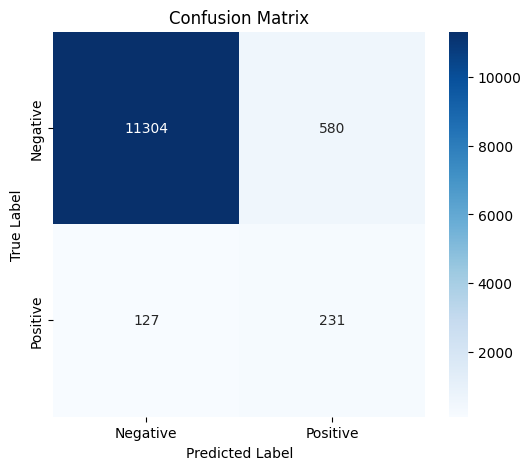

True Positives (TP): 231
False Positives (FP): 580
True Negatives (TN): 11304
False Negatives (FN): 127


In [9]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
data_2025 = pd.read_excel('/content/Fall 2025 3.18.25_processed.xlsx')
# Ensure that new_data has the same columns as the training data except for the target column
print(data_2025.columns)

new_data = data_2025[data_2025.drop(['admitted','Application Reference ID'], axis=1).columns]

print(new_data.shape[1])
data_2025_labels = data_2025['admitted'].to_numpy()

# Make sure new_data is a PyTorch tensor
new_data_tensor = torch.from_numpy(new_data.to_numpy()).float()

# Perform inference on the new data
with torch.no_grad():
    # Assuming your model is saved in 'save_net' after training
    outputs = save_net(new_data_tensor)

# Get predicted class labels from the outputs
predictions = torch.argmax(outputs, dim=1)

# If you want the predicted probabilities, you can use:
# probabilities = torch.softmax(outputs, dim=1)

# Convert predictions to numpy for further processing
predictions = predictions.numpy()

print("Predictions on new data:")
print(predictions)
total_predictions=len(predictions)
count_ones = (predictions == 1).sum()
print(f"Number of 1s in predictions: {count_ones}")
print(f"Number of 0s in predictions: {total_predictions - count_ones}")
print(f"Total number of predictions: {total_predictions}")


accuracy = accuracy_score(data_2025_labels,predictions)
precision = precision_score(data_2025_labels,predictions)
recall = recall_score(data_2025_labels, predictions)
f1_val = f1_score(data_2025_labels, predictions)
auc_roc = roc_auc_score(data_2025_labels, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))



# Compute Confusion Matrix
cm = confusion_matrix(data_2025_labels,predictions)

# Print the matrix
print("Confusion Matrix:\n", cm)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2025_labels,predictions)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")





In [8]:
#torch.save(save_net, "/content/predictionsiwth756&accuracy78.pth")

In [6]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# class NeuralNetwork(nn.Module):
#     def __init__(self, i, h_size, h_next_size, h_next_next_size=24, n_classes=2,
#                  how_many_layers=4, embedding_dim=300,hs_embedding_dim=300):
#         super(NeuralNetwork, self).__init__()

#         features = i.shape[1]  # Total number of input features

#         self.major_embedding = nn.Embedding(input_embedding_dimension, embedding_dim)

#         #embedding layer for the high school codes
#         self.hs_embedding=nn.Embedding(input_hs_embedding_dimension,hs_embedding_dim)

#         print(f"Setting major embedding dim: {input_embedding_dimension}")
#         print(f"Setting HS embedding dim: {input_hs_embedding_dimension}")

#         # Input to fc1 will be (features - 2) continuous + embedding_dim
#         self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
#         self.layers = how_many_layers

#         if self.layers == 2:
#             self.fc2 = nn.Linear(h_size, n_classes)
#         elif self.layers == 3:
#             self.fc3 = nn.Linear(h_size, h_next_size)
#             self.fc4 = nn.Linear(h_next_size, n_classes)
#         elif self.layers == 4:
#             self.fc3 = nn.Linear(h_size, h_next_size)
#             self.fc4 = nn.Linear(h_next_size, h_next_next_size)
#             self.fc5 = nn.Linear(h_next_next_size, n_classes)

#     def forward(self, X):
#         # Ensure input is float and extract categorical/continuous features
#         categorical_input = X[:, 0].long()  # First column: categorical (encoded)
#         hs_input = X[:,4].long()

#         #continuous_input = X[:, 1:].float() # Rest: continuous features
#         continuous_indices = [i for i in range(X.shape[1]) if i not in [0, 4]]
#         continuous_input = X[:, continuous_indices].float()

#         # Apply embedding
#         embedded = self.major_embedding(categorical_input)  # Shape: [batch_size, embedding_dim]
#         hs_embedded = self.hs_embedding(hs_input)

#         # Concatenate with continuous features
#         X = torch.cat((embedded,hs_embedded, continuous_input), dim=1)  # Shape: [batch_size, embedding_dim + (features-1)]

#         if self.layers == 2:
#             X = F.relu(self.fc1(X))
#             X = self.fc2(X)
#         elif self.layers == 3:
#             X = F.relu(self.fc1(X))
#             X = F.relu(self.fc3(X))
#             X = self.fc4(X)
#         elif self.layers == 4:
#             X = F.relu(self.fc1(X))
#             X = torch.tanh(self.fc3(X))
#             X = F.sigmoid(self.fc4(X))
#             X = self.fc5(X)

#         return X


# net = NeuralNetwork(inputs, h_size=40, h_next_size=32, how_many_layers=3)
# print(f"Expected input features to fc1: {train_inputs.shape[1] - 1 + 8}")  # Debug print
# print(f"fc1 weight shape: {net.fc1.weight.shape}")  # Debug printn_epochs = 600


# n_epochs = 600
# learning_rate = 0.0001
# decay_rate = learning_rate / n_epochs
# optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=decay_rate)
# lambda_reg = 0.001
# lambda_entropy = 0


# def loss_fn(model, outputs, targets):
#     # Convert labels to numpy
#     y_train = train_labels.numpy()

#     # Compute class weights
#     class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

#     # Convert to PyTorch tensor
#     class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

#     cross_entropy = nn.functional.cross_entropy(outputs, targets,weight=class_weights_tensor)
#     l2_regularization = 0
#     entropy_regularization = 0

#     for param in model.parameters():
#         l2_regularization += torch.norm(param, p=2) ** 2
#         entropy_regularization += torch.mean(torch.sum(-outputs * torch.log(outputs), dim=1))

#     loss = cross_entropy + lambda_reg * l2_regularization
#     return loss

# def test_instance(model):
#     y_t = []
#     y_s = []
#     loss = 0
#     acc = 0

#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             loss += loss_fn(model, outputs, labels.long())
#             y_t.extend(labels.numpy().astype('int'))
#             y_s.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

#     acc = accuracy_score(y_t, y_s)
#     return loss, acc

# iteration = 0
# counter = 0

# for epoch in range(n_epochs):
#     running_loss = 0.0
#     total = 0  # No. of total predictions
#     correct = 0  # No. of correct predictions

#     for i, (inputs, labels) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = loss_fn(net, outputs, labels.long())
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#     epoch_loss = running_loss / len(train_loader.dataset)  # Loss in every epoch
#     epoch_acc = correct / total  # Accuracy for every epoch

#     if epoch % 10 == 0 or epoch == n_epochs - 1:
#         print(f'Epoch: {epoch + 1}/{n_epochs} | pLoss: {running_loss / len(inputs)} | Accuracy: {epoch_acc} | Loss: {epoch_loss}')

#     if epoch % 50 == 0:
#         test_loss, test_acc = test_instance(net)
#         print(f'Epoch: {epoch + 1} | The test data Accuracy = {test_acc} | Test Loss = {test_loss}')

#         if counter < test_acc:
#             save_net = net
#             counter = test_acc

# y_true = []
# y_scores = []
# test_loss = 0

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         outputs = save_net(inputs)
#         test_loss += loss_fn(net, outputs, labels.long())
#         y_true.extend(labels.numpy().astype('int'))
#         y_scores.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())


# accuracy = accuracy_score(y_true, y_scores)
# precision = precision_score(y_true, y_scores)
# recall = recall_score(y_true, y_scores)
# f1_val = f1_score(y_true, y_scores)
# auc_roc = roc_auc_score(y_true, y_scores)

# print('Accuracy: {:.4f}'.format(accuracy))
# print('Precision: {:.4f}'.format(precision))
# print('Recall: {:.4f}'.format(recall))
# print('F1 Score: {:.4f}'.format(f1_val))
# print('AUROC Score: {:.4f}'.format(auc_roc))


In [7]:
# import pandas as pd
# import torch
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# data_2025 = pd.read_excel('/content/Fall 2025 3.12.25_processed_1.xlsx')
# # Ensure that new_data has the same columns as the training data except for the target column
# print(data_2025.columns)

# new_data = data_2025[data_2025.drop(['admitted','Application Reference ID'], axis=1).columns]

# print(new_data.shape[1])
# data_2025_labels = data_2025['admitted'].to_numpy()

# # Make sure new_data is a PyTorch tensor
# new_data_tensor = torch.from_numpy(new_data.to_numpy()).float()

# # Perform inference on the new data
# with torch.no_grad():
#     # Assuming your model is saved in 'save_net' after training
#     outputs = save_net(new_data_tensor)

# # Get predicted class labels from the outputs
# predictions = torch.argmax(outputs, dim=1)

# # If you want the predicted probabilities, you can use:
# # probabilities = torch.softmax(outputs, dim=1)

# # Convert predictions to numpy for further processing
# predictions = predictions.numpy()

# print("Predictions on new data:")
# print(predictions)
# total_predictions=len(predictions)
# count_ones = (predictions == 1).sum()
# print(f"Number of 1s in predictions: {count_ones}")
# print(f"Number of 0s in predictions: {total_predictions - count_ones}")
# print(f"Total number of predictions: {total_predictions}")


# accuracy = accuracy_score(data_2025_labels,predictions)
# precision = precision_score(data_2025_labels,predictions)
# recall = recall_score(data_2025_labels, predictions)
# f1_val = f1_score(data_2025_labels, predictions)
# auc_roc = roc_auc_score(data_2025_labels, predictions)

# print('Accuracy: {:.4f}'.format(accuracy))
# print('Precision: {:.4f}'.format(precision))
# print('Recall: {:.4f}'.format(recall))
# print('F1 Score: {:.4f}'.format(f1_val))
# print('AUROC Score: {:.4f}'.format(auc_roc))



# # Compute Confusion Matrix
# cm = confusion_matrix(data_2025_labels,predictions)

# # Print the matrix
# print("Confusion Matrix:\n", cm)

# # Plot the Confusion Matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.show()

# from sklearn.metrics import confusion_matrix

# # Compute Confusion Matrix
# cm = confusion_matrix(data_2025_labels,predictions)

# # Extract TP, TN, FP, FN
# TN = cm[0, 0]  # True Negative
# FP = cm[0, 1]  # False Positive
# FN = cm[1, 0]  # False Negative
# TP = cm[1, 1]  # True Positive

# print(f"True Positives (TP): {TP}")
# print(f"False Positives (FP): {FP}")
# print(f"True Negatives (TN): {TN}")
# print(f"False Negatives (FN): {FN}")



